In [1]:
# Data management
import pandas as pd
import numpy as np

# Models
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Visualitation
import seaborn as sns
import matplotlib.pyplot as plt

# Save model
import joblib

# Load data

In [2]:

data_raw = pd.read_json('webscrapi_fifa_players/data_fifa_players.json')
data_raw.columns

Index(['url', 'name', 'nation', 'overallrating', 'potencial', 'height',
       'weight', 'preferred_positions', 'Preferred Foot', 'Birth Date', 'Age',
       'Player Work Rate', 'Value', 'Wage', 'Contract Length', 'Ball Control',
       'Dribbling', 'Marking', 'Slide Tackle', 'Stand Tackle', 'Aggression',
       'Reactions', 'Att. Position', 'Interceptions', 'Vision', 'Composure',
       'Crossing', 'Short Pass', 'Long Pass', 'Acceleration', 'Stamina',
       'Strength', 'Balance', 'Sprint Speed', 'Agility', 'Jumping', 'Heading',
       'Shot Power', 'Finishing', 'Long Shots', 'Curve', 'FK Acc.',
       'Penalties', 'Volleys', 'GK Positioning', 'GK Diving', 'GK Handling',
       'GK Kicking', 'GK Reflexes'],
      dtype='object')

In [3]:
data_raw.shape

(18549, 49)

In [4]:
data_raw.head()

,url,name,nation,overallrating,potencial,height,weight,preferred_positions,Preferred Foot,Birth Date,...,Long Shots,Curve,FK Acc.,Penalties,Volleys,GK Positioning,GK Diving,GK Handling,GK Kicking,GK Reflexes
0,https://www.fifaindex.com/player/20801/cristia...,Cristiano Ronaldo,Portugal,91,91,187 cm,83 kg,[ST],Right,"Feb. 5, 1985",...,93.0,81.0,79.0,88.0,86.0,14,7,11,15,11
1,https://www.fifaindex.com/player/200389/jan-ob...,Jan Oblak,Slovenia,91,93,188 cm,87 kg,[GK],Right,"Jan. 7, 1993",...,12.0,13.0,14.0,11.0,13.0,90,87,92,78,90
2,https://www.fifaindex.com/player/189596/thomas...,Thomas Müller,Germany,87,87,185 cm,76 kg,"[CAM, RM, RW]",Right,"Sept. 13, 1989",...,82.0,81.0,59.0,70.0,84.0,14,6,7,11,14
3,https://www.fifaindex.com/player/231747/kylian...,Kylian Mbappé,France,91,95,182 cm,73 kg,"[ST, LW]",Right,"Dec. 20, 1998",...,82.0,80.0,69.0,79.0,83.0,11,13,5,7,6
4,https://www.fifaindex.com/player/158023/lionel...,Lionel Messi,Argentina,93,93,170 cm,72 kg,"[RW, ST, CF]",Left,"June 24, 1987",...,94.0,93.0,94.0,75.0,88.0,14,6,11,15,8


In [5]:
# drop url column
data_raw = data_raw.drop(columns=['url'])

# Clean

In [6]:
data_raw.isnull().values.any()

True

In [7]:
# NAs per column
data_raw.isnull().sum()

name                    0
nation                  0
overallrating           0
potencial               0
height                  0
weight                  0
preferred_positions     0
Preferred Foot          0
Birth Date              0
Age                     0
Player Work Rate        0
Value                  56
Wage                   54
Contract Length         0
Ball Control            3
Dribbling               3
Marking                 2
Slide Tackle            2
Stand Tackle            2
Aggression              2
Reactions               2
Att. Position           3
Interceptions           2
Vision                  3
Composure               2
Crossing                3
Short Pass              1
Long Pass               3
Acceleration            1
Stamina                 3
Strength                2
Balance                 1
Sprint Speed            1
Agility                 2
Jumping                 2
Heading                 2
Shot Power              3
Finishing               1
Long Shots  

In [8]:
# Drop NAs
data = data_raw.dropna().copy()
data.isnull().values.any()

False

In [9]:
data.shape

(18491, 48)

In [10]:
data.dtypes

name                    object
nation                  object
overallrating            int64
potencial                int64
height                  object
weight                  object
preferred_positions     object
Preferred Foot          object
Birth Date              object
Age                      int64
Player Work Rate        object
Value                   object
Wage                    object
Contract Length          int64
Ball Control           float64
Dribbling              float64
Marking                float64
Slide Tackle           float64
Stand Tackle           float64
Aggression             float64
Reactions              float64
Att. Position          float64
Interceptions          float64
Vision                 float64
Composure              float64
Crossing               float64
Short Pass             float64
Long Pass              float64
Acceleration           float64
Stamina                float64
Strength               float64
Balance                float64
Sprint S

In [11]:
# Change data types
# cm
data['height'] = data['height'].str.extract('(\\d+)').astype(int)
# kg
data['weight'] = data['weight'].str.extract('(\\d+)').astype(int)
# euros
data['Value'] = pd.to_numeric(data['Value'].str.replace('€|\\.', "", regex=True))
data['Wage'] = pd.to_numeric(data['Wage'].str.replace('€|\\.', "", regex=True))


In [12]:
# 3 principal positions zone are DEFENDING POSITION, MIDFIELD POSITION, ATTACKING POSITION
data['preferred_positions']


0                 [ST]
1                 [GK]
2        [CAM, RM, RW]
3             [ST, LW]
4         [RW, ST, CF]
             ...      
18544             [RW]
18545             [CM]
18546             [GK]
18547             [CF]
18548            [CAM]
Name: preferred_positions, Length: 18491, dtype: object

In [13]:
def get_position_zone(data):
    """Transform 'preferred_positions' to 'position_zone'"""
    position_zone = []
    for x in data['preferred_positions']:

        listb = {
            'DEFENDING': 0,
            'MIDFIELD': 0,
            'ATTACKING': 0,
            'GOALKEEPER': 0
                }
        for y in x:
            #print(y)
            if y in ['GK']:
                listb['GOALKEEPER'] = 1
            else: 
                if y in ['LF', 'RF', 'CF', 'ST' ]:
                    listb['ATTACKING'] = listb['ATTACKING'] + 1
                if y in ['CAM', 'RM', 'RW', 'CDM', 'CM', 'LM', 'LW']:
                    listb['MIDFIELD'] = listb['MIDFIELD'] + 1
                if y in ['LB', 'LWB', 'RB', 'RWB', 'CB']:
                    listb['DEFENDING'] = listb['DEFENDING'] + 1

        position_zone.append( max(listb, key=listb.get))
    
    return position_zone

    

In [14]:
position_zone = get_position_zone(data)
data.loc[:,'position_zone'] = position_zone
# drop preferred_positions column
data = data.drop(columns=['preferred_positions'])


In [15]:
data.head()

,name,nation,overallrating,potencial,height,weight,Preferred Foot,Birth Date,Age,Player Work Rate,...,Curve,FK Acc.,Penalties,Volleys,GK Positioning,GK Diving,GK Handling,GK Kicking,GK Reflexes,position_zone
0,Cristiano Ronaldo,Portugal,91,91,187,83,Right,"Feb. 5, 1985",36,High / Low,...,81.0,79.0,88.0,86.0,14,7,11,15,11,ATTACKING
1,Jan Oblak,Slovenia,91,93,188,87,Right,"Jan. 7, 1993",28,Medium / Medium,...,13.0,14.0,11.0,13.0,90,87,92,78,90,GOALKEEPER
2,Thomas Müller,Germany,87,87,185,76,Right,"Sept. 13, 1989",32,High / High,...,81.0,59.0,70.0,84.0,14,6,7,11,14,MIDFIELD
3,Kylian Mbappé,France,91,95,182,73,Right,"Dec. 20, 1998",23,High / Low,...,80.0,69.0,79.0,83.0,11,13,5,7,6,MIDFIELD
4,Lionel Messi,Argentina,93,93,170,72,Left,"June 24, 1987",34,Medium / Low,...,93.0,94.0,75.0,88.0,14,6,11,15,8,ATTACKING


# EDA

In [16]:
data.iloc[:, :25].describe()

,overallrating,potencial,height,weight,Age,Value,Wage,Contract Length,Ball Control,Dribbling,Marking,Slide Tackle,Stand Tackle,Aggression,Reactions,Att. Position,Interceptions,Vision,Composure,Crossing
count,18491.000000,18491.000000,18491.000000,18491.000000,18491.000000,1.849100e+04,18491.000000,18491.000000,18491.000000,18491.000000,18491.000000,18491.000000,18491.000000,18491.000000,18491.000000,18491.000000,18491.000000,18491.000000,18491.000000,18491.000000
mean,65.999135,70.964199,181.311503,74.979179,25.640744,2.850101e+06,9360.272565,2022.867882,58.731870,55.894381,46.986750,46.207182,48.407928,55.949219,61.757558,50.628414,47.023038,54.297712,58.310259,49.820453
std,6.699830,6.079989,6.872350,7.083474,4.740790,7.450478e+06,18422.752522,1.214841,16.562063,18.730829,20.180207,20.726258,21.203485,16.931688,8.811376,19.621191,20.652475,13.550698,12.012899,18.013861
min,47.000000,48.000000,155.000000,49.000000,17.000000,1.000000e+03,1500.000000,2021.000000,8.000000,4.000000,4.000000,5.000000,5.000000,10.000000,29.000000,2.000000,3.000000,10.000000,12.000000,6.000000
25%,62.000000,67.000000,176.000000,70.000000,22.000000,5.000000e+05,1600.000000,2022.000000,55.000000,50.000000,30.000000,26.000000,28.000000,45.000000,56.000000,40.000000,26.000000,45.000000,51.000000,39.000000
50%,66.000000,71.000000,181.000000,75.000000,25.000000,1.000000e+06,3400.000000,2023.000000,63.000000,62.000000,53.000000,53.000000,56.000000,59.000000,62.000000,56.000000,54.000000,56.000000,59.000000,54.000000
75%,70.000000,75.000000,186.000000,80.000000,29.000000,2.100000e+06,8900.000000,2024.000000,69.000000,68.000000,64.000000,63.000000,66.000000,69.000000,68.000000,65.000000,64.000000,64.000000,67.000000,63.000000
max,93.000000,95.000000,206.000000,110.000000,54.000000,1.940000e+08,350000.000000,2031.000000,96.000000,96.000000,93.000000,92.000000,92.000000,95.000000,94.000000,96.000000,90.000000,95.000000,96.000000,94.000000


In [17]:
data.iloc[:, 25:].describe()

,Short Pass,Long Pass,Acceleration,Stamina,Strength,Balance,Sprint Speed,Agility,Jumping,Heading,...,Long Shots,Curve,FK Acc.,Penalties,Volleys,GK Positioning,GK Diving,GK Handling,GK Kicking,GK Reflexes
count,18491.000000,18491.000000,18491.000000,18491.000000,18491.000000,18491.000000,18491.000000,18491.000000,18491.000000,18491.000000,...,18491.000000,18491.000000,18491.000000,18491.000000,18491.000000,18491.000000,18491.000000,18491.000000,18491.000000,18491.000000
mean,59.176681,53.442269,64.763939,63.334703,65.292196,64.163701,64.858796,63.672814,64.970472,52.011032,...,46.984966,47.546428,42.553567,48.040668,42.634741,16.271970,16.427343,16.214104,16.082473,16.530745
std,14.361134,14.887236,15.182796,16.039792,12.509843,14.298456,14.934348,14.821583,12.039807,17.320520,...,19.419134,18.188718,17.267055,15.818073,17.683775,17.153223,17.633274,16.902781,16.636695,17.945915
min,7.000000,9.000000,14.000000,12.000000,16.000000,15.000000,15.000000,18.000000,22.000000,5.000000,...,4.000000,6.000000,4.000000,7.000000,3.000000,2.000000,2.000000,2.000000,2.000000,2.000000
25%,55.000000,45.000000,57.000000,56.000000,58.000000,56.000000,58.000000,56.000000,58.000000,44.000000,...,32.000000,35.000000,31.000000,38.000000,30.000000,8.000000,8.000000,8.000000,8.000000,8.000000
50%,63.000000,56.000000,68.000000,67.000000,66.000000,66.000000,68.000000,66.000000,66.000000,55.000000,...,51.000000,49.000000,41.000000,49.000000,44.000000,11.000000,11.000000,11.000000,11.000000,11.000000
75%,68.000000,64.000000,75.000000,74.000000,74.000000,74.000000,75.000000,74.000000,73.000000,64.000000,...,62.000000,62.000000,55.000000,60.000000,56.000000,14.000000,14.000000,14.000000,14.000000,14.000000
max,93.000000,93.000000,97.000000,95.000000,97.000000,96.000000,97.000000,96.000000,95.000000,93.000000,...,94.000000,94.000000,94.000000,93.000000,90.000000,90.000000,91.000000,92.000000,93.000000,90.000000


In [18]:
data.describe(include=[object, bool])

,name,nation,Preferred Foot,Birth Date,Player Work Rate,position_zone
count,18491,18491,18491,18491,18491,18491
unique,18246,162,2,6255,9,4
top,Paulinho,England,Right,"Feb. 29, 1992",Medium / Medium,MIDFIELD
freq,5,1655,14032,123,9522,8068


In [19]:
df_positions = data.groupby("position_zone").median()
df_positions.reset_index(inplace=True)
df_positions

,position_zone,overallrating,potencial,height,weight,Age,Value,Wage,Contract Length,Ball Control,...,Long Shots,Curve,FK Acc.,Penalties,Volleys,GK Positioning,GK Diving,GK Handling,GK Kicking,GK Reflexes
0,ATTACKING,66.0,70.0,184.0,78.0,26.0,1000000.0,4100.0,2023.0,65.0,...,61.0,52.0,41.0,64.0,60.0,10.0,10.0,10.0,11.0,10.0
1,DEFENDING,66.0,70.0,183.0,75.0,25.0,950000.0,3300.0,2023.0,60.0,...,38.0,43.0,35.0,42.0,33.0,10.0,10.0,10.0,10.0,10.0
2,GOALKEEPER,64.0,69.0,188.0,81.0,26.0,525000.0,2200.0,2022.0,19.0,...,11.0,13.0,13.0,17.0,11.0,64.0,65.0,63.0,62.0,66.0
3,MIDFIELD,66.0,71.0,178.0,72.0,25.0,1200000.0,3800.0,2023.0,67.0,...,59.0,58.0,52.0,55.0,52.0,10.0,10.0,10.0,10.0,10.0


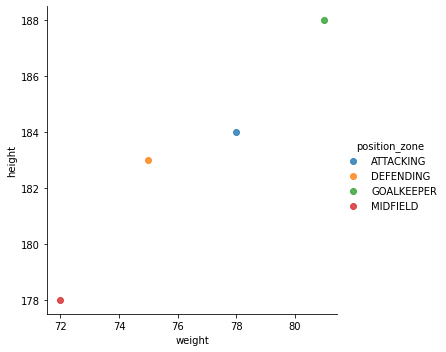

In [20]:
sns.lmplot(x="weight", y="height",data=df_positions, hue="position_zone")

In [21]:
data.columns

Index(['name', 'nation', 'overallrating', 'potencial', 'height', 'weight',
       'Preferred Foot', 'Birth Date', 'Age', 'Player Work Rate', 'Value',
       'Wage', 'Contract Length', 'Ball Control', 'Dribbling', 'Marking',
       'Slide Tackle', 'Stand Tackle', 'Aggression', 'Reactions',
       'Att. Position', 'Interceptions', 'Vision', 'Composure', 'Crossing',
       'Short Pass', 'Long Pass', 'Acceleration', 'Stamina', 'Strength',
       'Balance', 'Sprint Speed', 'Agility', 'Jumping', 'Heading',
       'Shot Power', 'Finishing', 'Long Shots', 'Curve', 'FK Acc.',
       'Penalties', 'Volleys', 'GK Positioning', 'GK Diving', 'GK Handling',
       'GK Kicking', 'GK Reflexes', 'position_zone'],
      dtype='object')

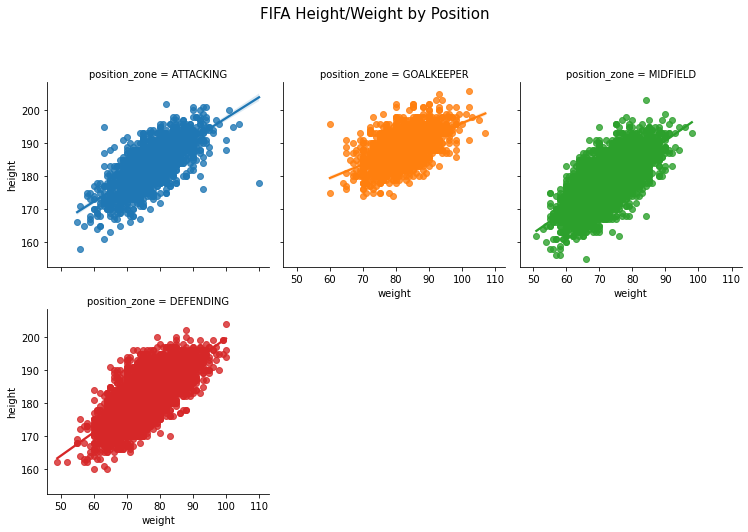

In [22]:

g = sns.FacetGrid(data, col="position_zone", height=3.5, col_wrap=3, hue="position_zone")
g.fig.suptitle("FIFA Height/Weight by Position", fontsize=15, y=1.05)
g.map(sns.regplot, "weight", "height")

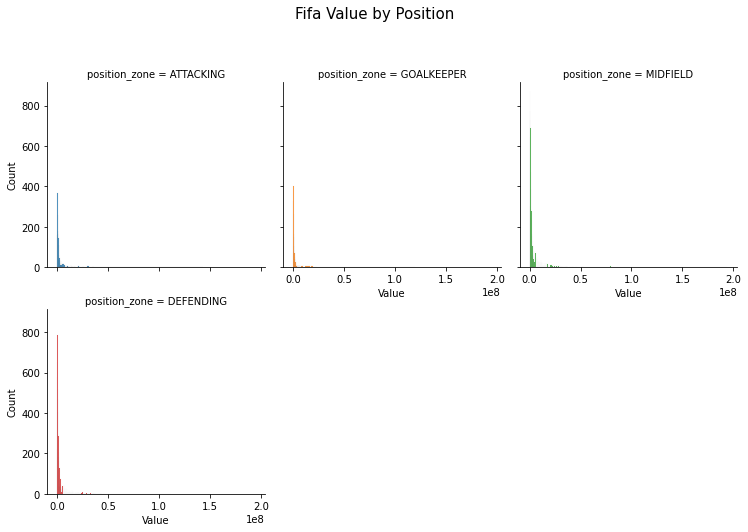

In [23]:
g = sns.FacetGrid(data, col="position_zone", height=3.5, col_wrap=3, hue="position_zone")
g.fig.suptitle("Fifa Value by Position", fontsize=15, y=1.05)
g.map(sns.histplot, "Value")

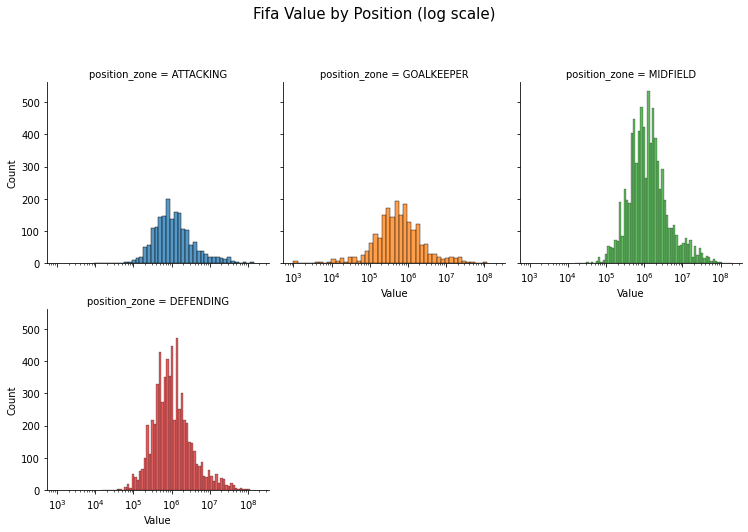

In [24]:
g = sns.FacetGrid(data, col="position_zone", height=3.5, col_wrap=3, hue="position_zone")
g.fig.suptitle("Fifa Value by Position (log scale)", fontsize=15, y=1.05)
g.map(sns.histplot, "Value", log_scale=True)

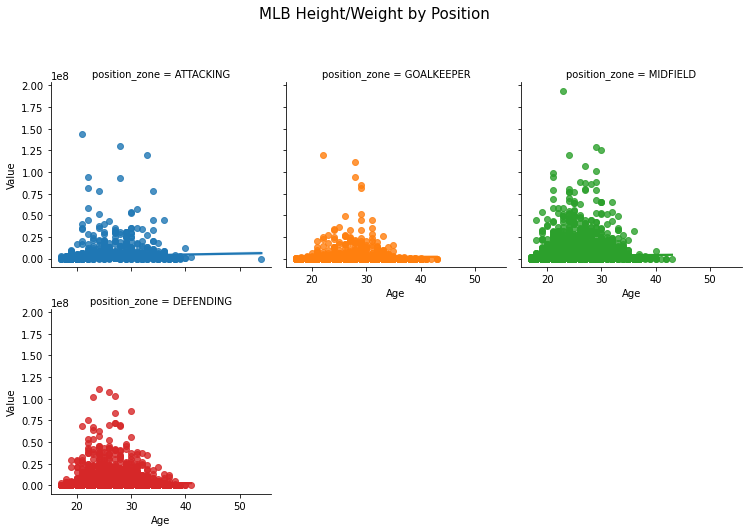

In [25]:
g = sns.FacetGrid(data, col="position_zone", height=3.5, col_wrap=3, hue="position_zone")
g.fig.suptitle("MLB Height/Weight by Position", fontsize=15, y=1.05)
g.map(sns.regplot, "Age", "Value")

Time to see the correlation

In [26]:
def plot_corr(column, data):
    plt.figure(figsize=(8, 12))
    heatmap = sns.heatmap(data[data['position_zone'] == column].corr()[['Value']].sort_values(by='Value', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
    heatmap.set_title(f'Features Correlating with Sales Price by "{column}"', fontdict={'fontsize':18}, pad=16)


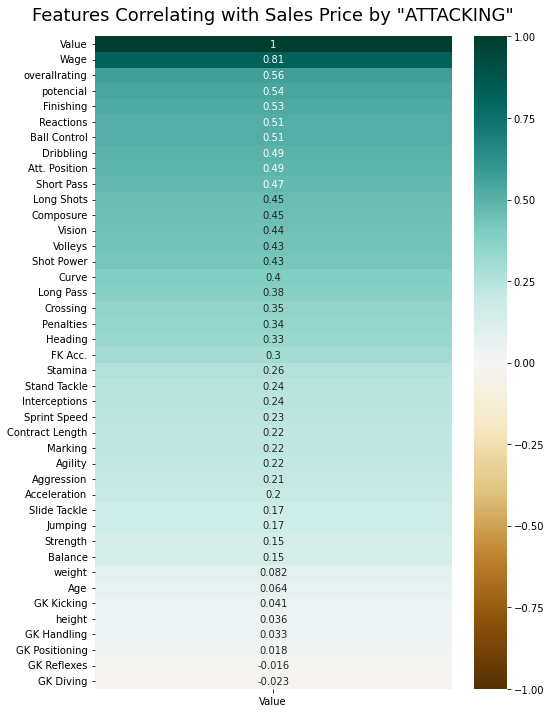

In [27]:

plot_corr("ATTACKING", data)

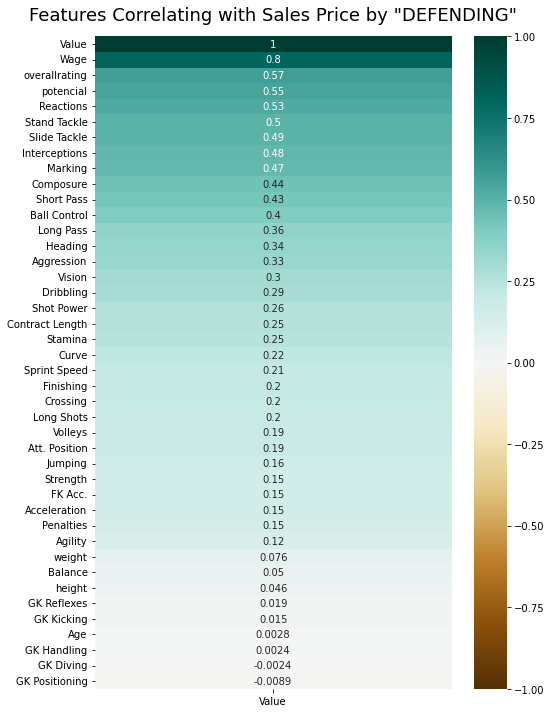

In [28]:
plot_corr('DEFENDING', data)

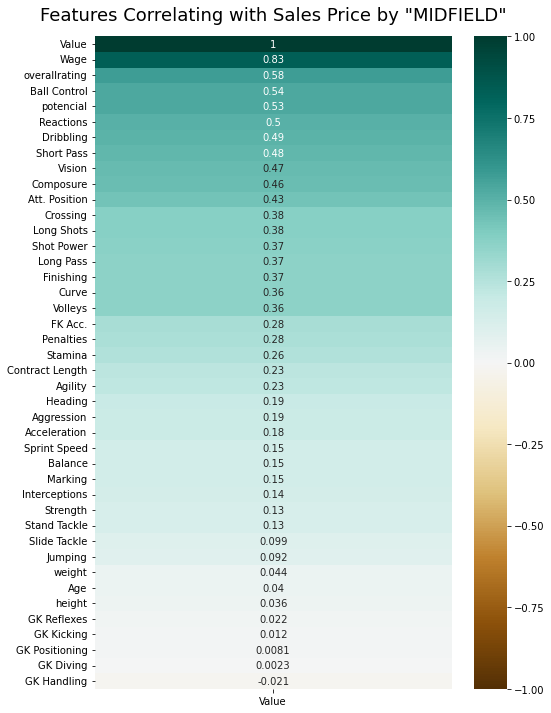

In [29]:
plot_corr("MIDFIELD", data)

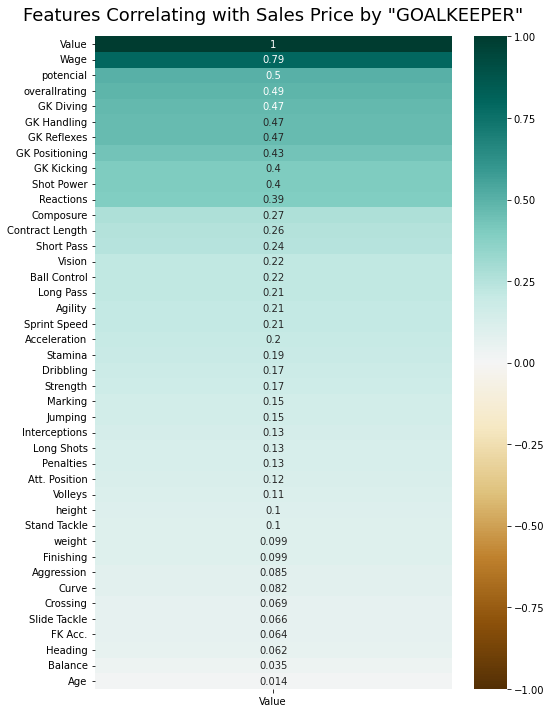

In [30]:
plot_corr("GOALKEEPER", data)

In [31]:
def one_hot_coding(data):
   """Conver columns type 'object' to one hot coding, then
      delete leaving only the One hot coding"""
   dummies_object = None
   columns_type_object = []

   for i, column_type in enumerate([str(d) for d in data.dtypes]):
     if column_type == "object":
       column_name = data.columns[i]
       columns_type_object.append(column_name)

       dummies = pd.get_dummies(data[column_name], prefix=column_name)

       if dummies_object is None:
         dummies_object = dummies
       else:
         dummies_object = pd.concat([dummies_object, dummies], axis=1)

   data = data.drop(columns_type_object, axis='columns')
   data = pd.concat([data, dummies_object], axis=1)
   return data

In [32]:
# Drop 'Wage', 'Birth Date', 'name', 'nation'
# are variables that are not so relevant to convert to one hot coding
data = data.drop(columns=['Wage', 'Birth Date', 'name', 'nation'])
data_one_hot = one_hot_coding(data)
data_one_hot.head()

,overallrating,potencial,height,weight,Age,Value,Contract Length,Ball Control,Dribbling,Marking,...,Player Work Rate_Low / High,Player Work Rate_Low / Low,Player Work Rate_Low / Medium,Player Work Rate_Medium / High,Player Work Rate_Medium / Low,Player Work Rate_Medium / Medium,position_zone_ATTACKING,position_zone_DEFENDING,position_zone_GOALKEEPER,position_zone_MIDFIELD
0,91,91,187,83,36,45000000,2023,88.0,88.0,24.0,...,0,0,0,0,0,0,1,0,0,0
1,91,93,188,87,28,112000000,2023,30.0,12.0,27.0,...,0,0,0,0,0,1,0,0,1,0
2,87,87,185,76,32,66000000,2023,84.0,77.0,47.0,...,0,0,0,0,0,0,0,0,0,1
3,91,95,182,73,23,194000000,2022,91.0,93.0,26.0,...,0,0,0,0,0,0,0,0,0,1
4,93,93,170,72,34,78000000,2023,96.0,96.0,20.0,...,0,0,0,0,1,0,1,0,0,0


Text(0.5, 1.0, 'Features Correlating with Sales Price by "ATTACKING"')

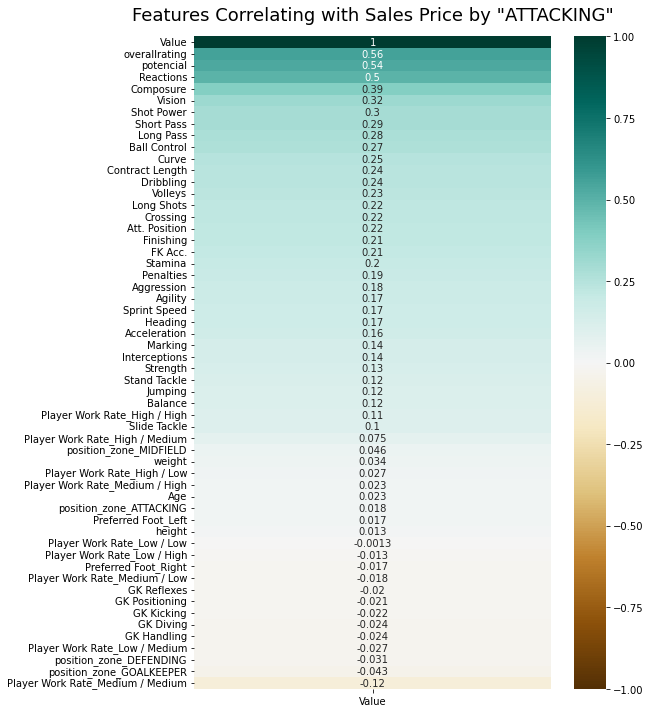

In [33]:
# now the correlation values in one hot data
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(data_one_hot.corr()[['Value']].sort_values(by='Value', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Sales Price by "ATTACKING"', fontdict={'fontsize':18}, pad=16)

# Modeling

In [34]:
y = data_one_hot['Value'].values #Target
# Transform to log
y = np.log(y)
y = y.reshape(-1, 1)
X = data_one_hot.drop(columns=['Value']) #Feature(s)


In [35]:
print(y.shape)
print(X.shape)


(18491, 1)
(18491, 55)


# Split Data and Scale Data

In [36]:
scaler = StandardScaler()
X_scaler = scaler.fit(X)
X = X_scaler.transform(X)
X

array([[ 3.73166801,  3.29545702,  0.82775923, ..., -0.73468486,
        -0.35320913, -0.8798053 ],
       [ 3.73166801,  3.62441387,  0.9732738 , ..., -0.73468486,
         2.83118388, -0.8798053 ],
       [ 3.13462179,  2.63754332,  0.53673008, ..., -0.73468486,
        -0.35320913,  1.13661511],
       ...,
       [-2.83584037, -1.14546045,  0.68224466, ..., -0.73468486,
         2.83118388, -0.8798053 ],
       [-2.83584037, -1.14546045, -2.95561968, ..., -0.73468486,
        -0.35320913, -0.8798053 ],
       [-2.83584037, -1.63889572, -0.19084278, ..., -0.73468486,
        -0.35320913,  1.13661511]])

In [37]:
y_scaler = scaler.fit(y)
y

array([[17.62217305],
       [18.53400943],
       [18.0051653 ],
       ...,
       [11.51292546],
       [11.69524702],
       [11.60823564]])

In [38]:
y = y_scaler.transform(y)
y

array([[ 2.9722143 ],
       [ 3.69924451],
       [ 3.27758371],
       ...,
       [-1.89884328],
       [-1.75347369],
       [-1.82285006]])

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(14792, 55) (14792, 1)
(3699, 55) (3699, 1)


# Fit the model

We need a baseline to know if each selected model really improves the prediction or not.
For this task we will resort to the basic but powerful linear regression.

In [40]:

clf = LinearRegression()
model = clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

In [41]:
y_scaler.inverse_transform(y_test)

array([[16.73328129],
       [15.8949521 ],
       [13.45883561],
       ...,
       [13.45883561],
       [14.07787482],
       [13.56061831]])

In [42]:
y_scaler.inverse_transform(predictions)

array([[16.26654352],
       [15.91936529],
       [13.53679986],
       ...,
       [13.57967617],
       [13.93079492],
       [13.98048656]])

In [43]:
d = {
    'y_test': np.squeeze(y_scaler.inverse_transform(y_test)),
    'predictions': np.squeeze(y_scaler.inverse_transform(predictions))

    }
pd.DataFrame(d)

,y_test,predictions
0,16.733281,16.266544
1,15.894952,15.919365
2,13.458836,13.536800
3,13.910821,14.050525
4,13.345507,13.659761
...,...,...
3694,15.341567,14.906809
3695,15.250595,15.482127
3696,13.458836,13.579676
3697,14.077875,13.930795


e:\Documents\pruebas\value_fifa_players\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Predicted Value')

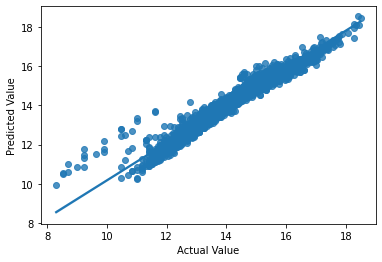

In [44]:
plot = sns.regplot(y_scaler.inverse_transform(y_test), y_scaler.inverse_transform(predictions))
plt.xlabel("Actual Value")
plt.ylabel("Predicted Value")

In [45]:
rmse_xgb_reg = mean_squared_error(y_scaler.inverse_transform(y_test), y_scaler.inverse_transform(predictions), squared=False)

print(f"The RMSE for xgb_reg is: {rmse_xgb_reg}")

The RMSE for xgb_reg is: 0.2878024409973715


Ok, once we have established our base line, it is time to apply RandomizedSearchCV to iterate through different options.

## XGBRegressor model

In [46]:

parameters = { 
        "param_distributions":{
                'max_depth': [ 3, 6, 10],
                'learning_rate': [0.01, 0.05, 0.1, .3, .5],
                'n_estimators': [100, 500, 1000],
                'colsample_bytree': [ 0.7, .5]
                },
        'scoring':'neg_mean_squared_error',
        'verbose':3,
        'n_jobs':-1
        }
        
xgb_model = XGBRegressor(seed = 20)

In [47]:
xgb_grid  = RandomizedSearchCV(estimator=xgb_model, **parameters)

In [48]:
fit_model = xgb_grid.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


e:\Documents\pruebas\value_fifa_players\venv\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [49]:
fit_model.best_params_

{'n_estimators': 1000,
 'max_depth': 6,
 'learning_rate': 0.05,
 'colsample_bytree': 0.5}

In [50]:
predictions = fit_model.predict(X_test)

In [51]:
y_scaler.inverse_transform(predictions.reshape(-1, 1))

array([[16.793419],
       [15.855971],
       [13.447143],
       ...,
       [13.272698],
       [14.108471],
       [13.572572]], dtype=float32)

In [52]:
d = {
    'real': np.squeeze(y_scaler.inverse_transform(y_test)),
    'predictions': np.squeeze(y_scaler.inverse_transform(predictions.reshape(-1, 1)))

    }
pd.DataFrame(d)

,real,predictions
0,16.733281,16.793419
1,15.894952,15.855971
2,13.458836,13.447143
3,13.910821,13.896465
4,13.345507,13.362029
...,...,...
3694,15.341567,15.134054
3695,15.250595,15.242031
3696,13.458836,13.272698
3697,14.077875,14.108471


e:\Documents\pruebas\value_fifa_players\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Predicted Value')

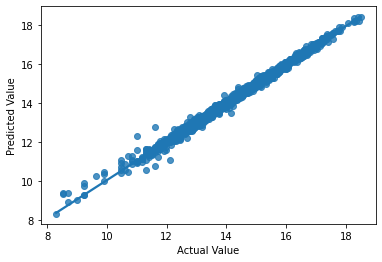

In [53]:
plot = sns.regplot(y_scaler.inverse_transform(y_test), y_scaler.inverse_transform([predictions]))
plt.xlabel("Actual Value")
plt.ylabel("Predicted Value")


In [54]:
rmse_xgb_reg = mean_squared_error(y_scaler.inverse_transform(y_test), y_scaler.inverse_transform(predictions.reshape(-1, 1)), squared=False)

print(f"The RMSE for xgb_reg is: {rmse_xgb_reg}")

The RMSE for xgb_reg is: 0.09952574180853953


# Export Model

In [55]:
joblib.dump(model, 'model.joblib')

## Verify Model Import

In [56]:
clf_disk = joblib.load("model.joblib")

## Test Predict From Model Loaded From Disk

In [57]:
data = data_raw.dropna().copy()
# Change data types
# cm
data['height'] = data['height'].str.extract('(\d+)').astype(int)
# kg
data['weight'] = data['weight'].str.extract('(\d+)').astype(int)
# euros
data['Value'] = pd.to_numeric(data['Value'].str.replace('€|\.', "", regex=True))
data['Wage'] = pd.to_numeric(data['Wage'].str.replace('€|\.', "", regex=True))

In [58]:
position_zone = get_position_zone(data)
data.loc[:,'position_zone'] = position_zone
# drop preferred_positions column
data = data.drop(columns=['preferred_positions', 'Wage', 'Birth Date', 'name', 'nation'])
data_one_hot = one_hot_coding(data)


In [59]:
# Watch the actual value
data_one_hot.loc[data_raw['name'] == 'Takumi Minamino']['Value']

1566    6500000
Name: Value, dtype: int64

In [60]:
pX = data_one_hot.loc[data_raw['name'] == 'Takumi Minamino']#Feature(s)
pX = pX.drop(columns=['Value'])
pX

,overallrating,potencial,height,weight,Age,Contract Length,Ball Control,Dribbling,Marking,Slide Tackle,...,Player Work Rate_Low / High,Player Work Rate_Low / Low,Player Work Rate_Low / Medium,Player Work Rate_Medium / High,Player Work Rate_Medium / Low,Player Work Rate_Medium / Medium,position_zone_ATTACKING,position_zone_DEFENDING,position_zone_GOALKEEPER,position_zone_MIDFIELD
1566,75,76,174,67,26,2024,78.0,81.0,32.0,26.0,...,0,0,0,0,0,0,0,0,0,1


In [61]:
X = data_one_hot.drop(columns=['Value']) #Feature(s)

In [62]:
y = data_one_hot['Value'].values #Target
# Transform to log
y = np.log(y)
y = y.reshape(-1, 1)
X = data_one_hot.drop(columns=['Value']) #Feature(s)

In [63]:
scaler = StandardScaler()
input_scaler = scaler.fit(X)
scaled_input = input_scaler.transform(pX)


In [64]:
scaled_input

array([[ 1.34348314,  0.82828065, -1.06393022, -1.12648039,  0.07578179,
         0.93193216,  1.16342099,  1.34037302, -0.74266609, -0.97498197,
        -0.86817926,  0.29831155,  1.27593532,  1.0892389 ,  0.09572776,
         1.15881204,  1.72234036,  0.89819636,  0.82330818,  0.64202576,
         1.2011328 ,  0.7896386 , -0.82275009,  1.52722012,  0.67907071,
         1.70885064,  0.91611323, -0.11611007,  0.98741653,  1.51711644,
         1.33969612,  1.39945322,  1.53165366,  1.51472176,  1.54752017,
        -0.07415543, -0.42122319, -0.24932098, -0.48583514, -0.14102446,
        -0.56371417,  0.56371417, -0.25283206, -0.20788409,  2.03732579,
        -0.15503226, -0.04993897, -0.15865208, -0.32869698, -0.2077425 ,
        -1.03036732, -0.33741453, -0.73468486, -0.35320913,  1.13661511]])

In [67]:
result = clf_disk.predict(scaled_input)
print(f"Unscaled prediction: {float(np.round(result, 2))}")
transformed_prediction = y_scaler.inverse_transform(result) 
print(f"transformed_prediction: {float(np.round(transformed_prediction, 2))}")

print(f"value_money: {float(np.round(np.exp(transformed_prediction), 2))}")

Unscaled prediction: 1.41
transformed_prediction: 15.66
value_money: 6330106.07
